[Click here for the Tableau Public link](https://public.tableau.com/views/CapstoneHC/Dashboard1?:language=en&:display_count=y&publish=yes&:origin=viz_share_link)

# Importing Basic Libraries and Dataset

In [1]:
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz as sv
from termcolor import colored
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

from collections import Counter

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

In [2]:
df = pd.read_csv('../Dataset/health care diabetes.csv')

df_copy = df.copy()

In [3]:
df.shape # Check the shape of the dataset

(768, 9)

In [4]:
# my_report = sv.analyze([df, "Healthcare Diabetes"], "Outcome")
# report_url = "file:///C:/Users/kunte/Desktop/Ongoing%20Project/Capstone%20Healthcare/RK_codes/Healthcare%20Diabetes%20Report.html"
# my_report.show_html()

In [5]:
feat_colNames = ['Pregnancies', 'Glucose', 'BloodPressure',
                 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
label_colName = ['Outcome']

In [6]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
df.info() #Check for Missing Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Checking and Handling Inappropriate Data

## Check for Duplicate Rows and Cols

In [9]:
# No duplicate Rows and Columns

df.drop_duplicates(inplace=True)
df.set_index(np.arange(0,len(df)) , inplace=False)
df.columns 

print("No duplicate Rows and Columns")

No duplicate Rows and Columns


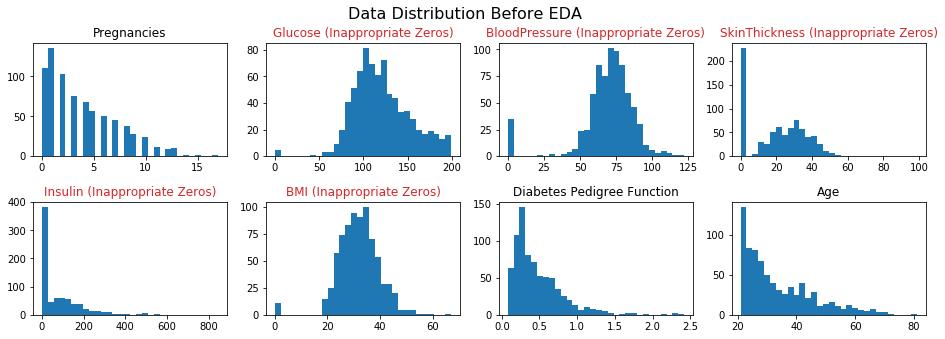

In [10]:
#fig and axs variable for creating a sub-plot of (2 rows, 4 columns) with figure size (hor,ver)

fig, axs = plt.subplots(2, 4, figsize=(16, 5))

axs[0, 0].hist(df.Pregnancies, bins=30)
axs[0, 1].hist(df.Glucose, bins=30)
axs[0, 2].hist(df.BloodPressure, bins=30)
axs[0, 3].hist(df.SkinThickness, bins=30)
axs[1, 0].hist(df.Insulin, bins=30)
axs[1, 1].hist(df.BMI, bins=30)
axs[1, 2].hist(df.DiabetesPedigreeFunction, bins=30)
axs[1, 3].hist(df.Age, bins=30)


axs[0, 0].set_title("Pregnancies")
axs[0, 1].set_title("Glucose (Inappropriate Zeros)", color='C3')
axs[0, 2].set_title("BloodPressure (Inappropriate Zeros)", color='C3')
axs[0, 3].set_title("SkinThickness (Inappropriate Zeros)", color='C3')
axs[1, 0].set_title("Insulin (Inappropriate Zeros)", color='C3')
axs[1, 1].set_title("BMI (Inappropriate Zeros)", color='C3')
axs[1, 2].set_title("Diabetes Pedigree Function")
axs[1, 3].set_title("Age")

fig.suptitle('Data Distribution Before EDA', fontsize=16)
plt.subplots_adjust(hspace=0.4, wspace=0.2)  #This is to avoid overlapping 

## Dealing with the Inappropriate Zero Values: According to Domain Knowledge

In [11]:
#Following are the Columns where '0' is a placeholder to indicate that the record was missing / uncaptured. ['inapp_cols']

inapp_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

tot = int(df.shape[0]) #total number of records

for col in inapp_cols:
    print("{}: {} zero(s) | {:.2f}%".format(col,(len(df[(df[col] == 0)])),((len(df[(df[col] == 0)]))/tot)*100))
    df[col].loc[df[col] == 0] = np.nan
    
print("\n----------------------------------------------\n")

for col in inapp_cols:
    print("{}: {} zero(s) replaced with NaN.".format(col,(len(df[(df[col] == 0)]))))
    df[col].loc[df[col] == 0] = np.nan

Glucose: 5 zero(s) | 0.65%
BloodPressure: 35 zero(s) | 4.56%
SkinThickness: 227 zero(s) | 29.56%
Insulin: 374 zero(s) | 48.70%
BMI: 11 zero(s) | 1.43%

----------------------------------------------

Glucose: 0 zero(s) replaced with NaN.
BloodPressure: 0 zero(s) replaced with NaN.
SkinThickness: 0 zero(s) replaced with NaN.
Insulin: 0 zero(s) replaced with NaN.
BMI: 0 zero(s) replaced with NaN.


# Checking and Handling 'Missing Data'

Glucose: 5 zero(s) | __0.65%__<br>
BloodPressure: 35 zero(s) | __04.56%__ <br>
SkinThickness: 227 zero(s) | __029.56%__ <br>
Insulin: 374 zero(s) | __048.70%__ <br>
BMI: 11 zero(s) | __01.43%__

## Replace Missing Values with the Column Mean/Median/Mode

In [12]:
df.Glucose.fillna(int(df.Glucose.mean()), inplace=True)                    
df.BloodPressure.fillna(int(df.BloodPressure.mean()), inplace=True)      
df.SkinThickness.fillna(int(df.SkinThickness.mean()), inplace=True)      
df.Insulin.fillna(int(df.Insulin.mean()), inplace=True)                  
df.BMI.fillna(df.BMI.mean(), inplace=True)    

#There is scope of improvement here :
# - We can fill the NaN values with a multi variate regressor for 'SkinThickness' and 'Insulin' 

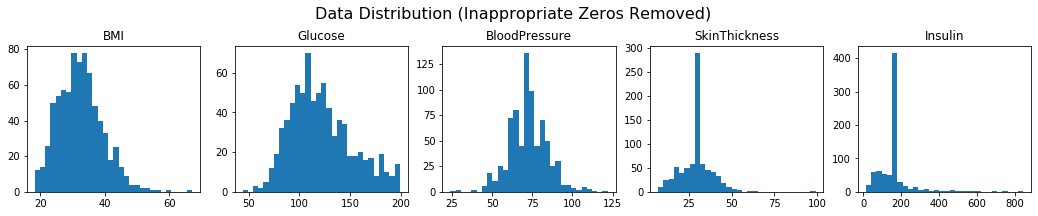

In [13]:
fig_1, axs_1 = plt.subplots(1, 5, figsize=(18, 3))

axs_1[0].hist(df.BMI, bins=30)
axs_1[1].hist(df.Glucose, bins=30)
axs_1[2].hist(df.BloodPressure, bins=30)
axs_1[3].hist(df.SkinThickness, bins=30)
axs_1[4].hist(df.Insulin, bins=30)

axs_1[0].set_title("BMI")
axs_1[1].set_title("Glucose")
axs_1[2].set_title("BloodPressure")
axs_1[3].set_title("SkinThickness")
axs_1[4].set_title("Insulin")

fig_1.suptitle('Data Distribution (Inappropriate Zeros Removed)', fontsize=16)
plt.subplots_adjust(top= 0.8, hspace=0.4, wspace=0.2)  #This is to avoid overlapping 

In [14]:
df.to_csv('Diabetes Data.csv', encoding='utf-8')

# Distribution Analysis

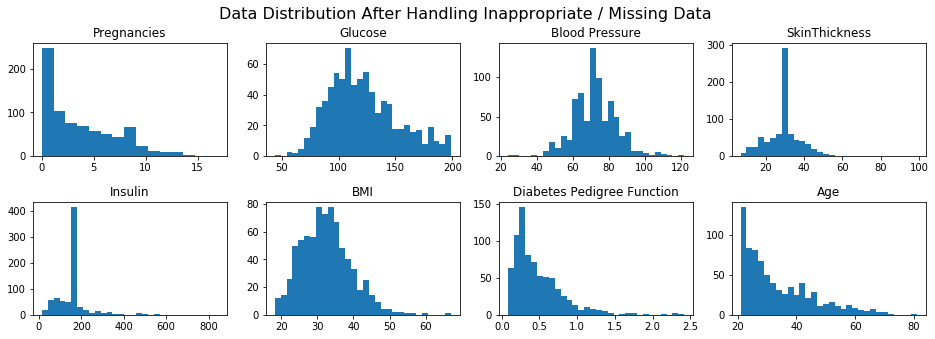

In [15]:
fig_1, axs_1 = plt.subplots(2, 4, figsize=(16, 5))

axs_1[0, 0].hist(df.Pregnancies, bins= 15)
axs_1[0, 1].hist(df.Glucose, bins=30)
axs_1[0, 2].hist(df.BloodPressure, bins=30)
axs_1[0, 3].hist(df.SkinThickness, bins=30)
axs_1[1, 0].hist(df.Insulin, bins=30)
axs_1[1, 1].hist(df.BMI, bins=30)
axs_1[1, 2].hist(df.DiabetesPedigreeFunction, bins=30)
axs_1[1, 3].hist(df.Age, bins=30)


axs_1[0, 0].set_title("Pregnancies")
axs_1[0, 1].set_title("Glucose")
axs_1[0, 2].set_title("Blood Pressure")
axs_1[0, 3].set_title("SkinThickness")
axs_1[1, 0].set_title("Insulin")
axs_1[1, 1].set_title("BMI")
axs_1[1, 2].set_title("Diabetes Pedigree Function")
axs_1[1, 3].set_title("Age")

fig_1.suptitle('Data Distribution After Handling Inappropriate / Missing Data', fontsize=16)
plt.subplots_adjust(hspace=0.4, wspace=0.2)  #This is to avoid overlapping 

__Top 3 Most Common Values__

In [16]:
col_1 = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness']
col_2 = ['Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

In [17]:
for col in col_1:
    print(df[col].value_counts().head(3),"\n")

1    135
0    111
2    103
Name: Pregnancies, dtype: int64 

100.0    17
99.0     17
111.0    14
Name: Glucose, dtype: int64 

72.0    79
70.0    57
74.0    52
Name: BloodPressure, dtype: int64 

29.0    244
32.0     31
30.0     27
Name: SkinThickness, dtype: int64 



In [18]:
for col in col_2:
    print(df[col].value_counts().head(3),"\n")

155.0    378
105.0     11
140.0      9
Name: Insulin, dtype: int64 

32.0    13
31.2    12
31.6    12
Name: BMI, dtype: int64 

0.254    6
0.258    6
0.259    5
Name: DiabetesPedigreeFunction, dtype: int64 

22    72
21    63
25    48
Name: Age, dtype: int64 



## Normalised Dataset

In [19]:
scaler = MinMaxScaler()

df_norm = df
df_norm = scaler.fit_transform(df)
df_norm= pd.DataFrame(df_norm, columns= df.columns)

# Checking and Handling Unbalanced Dataset

## Over Sampling using SMOTETomek

In [20]:
no_dia = df[df['Outcome'] == 0]
yes_dia = df[df['Outcome'] == 1]

text_overSampling_0 = colored('Checking Data Distribution (Bal/Unbal?)',
                              color='green', attrs=['bold', 'reverse', 'blink'])
print(text_overSampling_0)
print("Negatives: {}\nPositives: {}\n".format(
    no_dia.shape[0], yes_dia.shape[0]))

X = df[feat_colNames]
Y = df[label_colName]

(X.values).shape

smk = SMOTETomek(random_state=42, n_jobs=-1)
X_res, y_res = smk.fit_resample(X.values, Y.values)

text_overSampling_1 = colored(
    'After Over-Sampling', color='cyan', attrs=['bold', 'reverse', 'blink'])
print(text_overSampling_1)
print('Original dataset shape {}\nResampled dataset shape {}\n'.format(
    Counter(Y.Outcome), Counter(y_res)))

df_overSampling = pd.DataFrame(X_res, columns=feat_colNames)

df_overSampling['Outcome'] = y_res

print("Original Dataset Shape: {}\nPost Over-Sampling Dataset Shape: {}".format(df.shape,
                                                                           df_overSampling.shape))

df_overSampling.head()

Checking Data Distribution (Bal/Unbal?)
Negatives: 500
Positives: 268

After Over-Sampling
Original dataset shape Counter({0: 500, 1: 268})
Resampled dataset shape Counter({1: 477, 0: 477})

Original Dataset Shape: (768, 9)
Post Over-Sampling Dataset Shape: (954, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,155.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,155.0,26.6,0.351,31.0,0
2,8.0,183.0,64.0,29.0,155.0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1


## Balanced / Unbalanced Visualisation

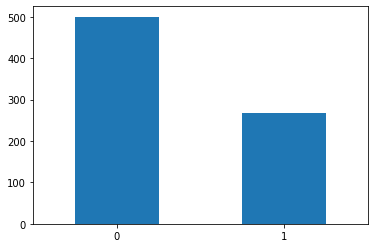

In [21]:
df['Outcome'].value_counts().plot(kind='bar', rot=0)

# Feature Engineering

In [22]:
features_overSampling = df_overSampling.iloc[:,:-1].values
label_overSampling = df_overSampling.iloc[:,[-1]].values

features = df.iloc[:,:-1].values
label = df.iloc[:,[-1]].values

## Pairplot for Visualising Feature Correlations with "__<font color = 'orange'>OUT</font><font color = 'blue'>COME</font>__" (Label) as hue<br>__Wall time: 1min 16s__

In [23]:
# f = sns.PairGrid(df, hue = 'Outcome')
# f.map_diag(plt.hist)
# f.map_upper(plt.scatter)
# f.map_lower(sns.kdeplot)
# f.add_legend()

![''](Correlation.png)

## Boxplot: "Outcome" Label Overview

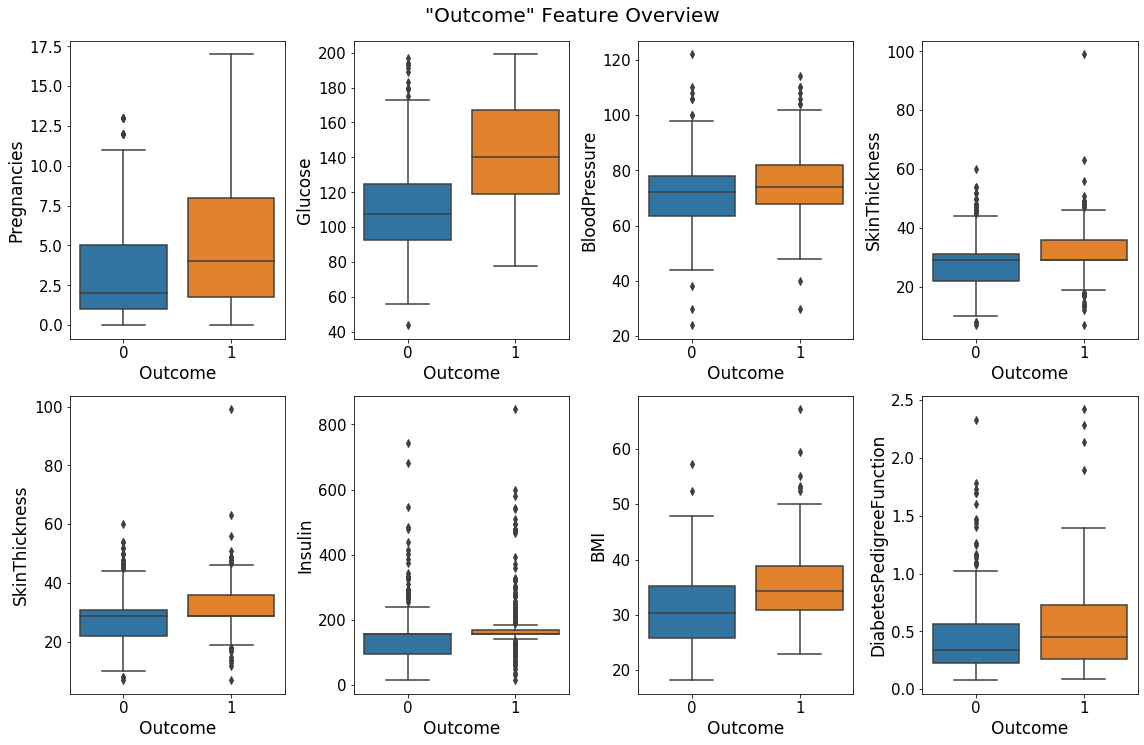

In [24]:
fig, ax = plt.subplots(2,4, figsize=(16,10))

for j in range(len(ax)):
    for i in range(len(ax[j])):
        ax[j][i].tick_params(labelsize=15)
        ax[j][i].set_xlabel('label', fontsize=17, position=(.5,20))
        ax[j][i].set_ylabel('label', fontsize=17)
        
        if j ==0:
            ax[j][i] = sns.boxplot(x="Outcome", y=feat_colNames[i], data=df, ax=ax[j][i])#, jitter=0.3)
        elif j==1:
            ax[j][i] = sns.boxplot(x="Outcome", y=feat_colNames[i+3], data=df, ax=ax[j][i])#, jitter=0.3)
            
fig.suptitle('"Outcome" Feature Overview', position=(.5,1.03), fontsize=20)
fig.tight_layout()

## Heatmap for Visualising Correlation Analysis<br> <font color = 'red'>Threashold = 0.5</font>

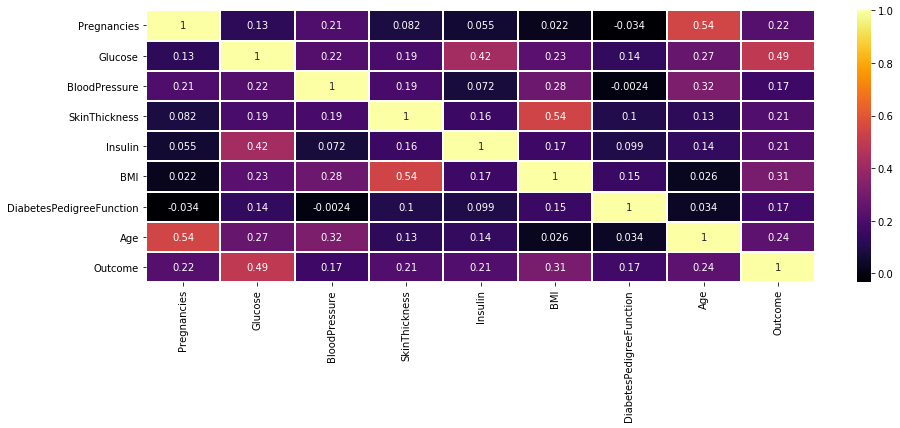

In [25]:
# df_corr = df_overSampling.corr()

df_corr = df.corr()
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(df_corr, linewidths= 1, annot=True, cmap='inferno', ax=ax)

In [26]:
df_corr['Outcome_round'] = round(df_corr['Outcome'], 1)
print(df_corr.Outcome_round)

Pregnancies                 0.2
Glucose                     0.5
BloodPressure               0.2
SkinThickness               0.2
Insulin                     0.2
BMI                         0.3
DiabetesPedigreeFunction    0.2
Age                         0.2
Outcome                     1.0
Name: Outcome_round, dtype: float64


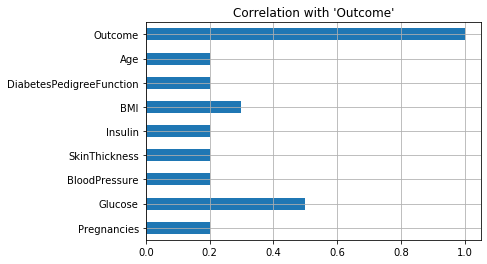

In [27]:
df_corr.Outcome_round.plot(kind='barh', title="Correlation with 'Outcome'", grid=True)

In [28]:
#According to the Correlation Analysis, only the 'Glucose' is important.

feat_corr = df_corr[(df_corr.Outcome_round >= 0.5) & (df_corr.Outcome_round < 1.0)].index[0]

In [29]:
print("--------------")
print("According to Correlation Analysis, Impotant Feature(s): ", colored("'{}'".format(feat_corr), 'blue', attrs= ['reverse', 'bold']))
print("--------------")

--------------
According to Correlation Analysis, Impotant Feature(s):  'Glucose'
--------------


## Feature Select By Model (SBM | Logistic Regression)

In [30]:
from sklearn.linear_model import LogisticRegression

modelForSBM = LogisticRegression()


from sklearn.feature_selection import SelectFromModel

selectFeatures_SBM = SelectFromModel(modelForSBM)

selectFeatures_SBM.fit(features,label)

# print("Features: \n{}\n".format(feat_colNames))
# print("Feature Index Number(s): {}\n".format(selectFeatures_SBM.get_support(indices=True)[0]))

SelectFromModel(estimator=LogisticRegression())

In [31]:
print("--------------")
print("According to SBM (Log_Reg), Impotant Feature(s): ", colored("{}".format(feat_colNames[selectFeatures_SBM.get_support(indices=True)[0]]), 'blue', attrs= ['reverse', 'bold']))
print("--------------")

--------------
According to SBM (Log_Reg), Impotant Feature(s):  DiabetesPedigreeFunction
--------------


## Analysis of variance (Univariate Analysis using ANOVA)

In [32]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif

selectFeaturesANOVA = SelectPercentile(percentile=50, score_func=f_classif)

selectFeaturesANOVA.fit(features,label)

# print(feat_colNames)
# print(selectFeaturesANOVA.get_support(indices=False))
# print(selectFeaturesANOVA.get_support(indices=True))

feat_ANOVA = []
for idx in selectFeaturesANOVA.get_support(indices=True):
    feat_ANOVA.append(feat_colNames[idx])

In [33]:
print("--------------")
print("According to ANOVA, Impotant Feature(s): ", colored("{}".format(feat_ANOVA), 'blue', attrs= ['reverse', 'bold']))
print("--------------")

--------------
According to ANOVA, Impotant Feature(s):  ['Pregnancies', 'Glucose', 'BMI', 'Age']
--------------


## Recursive Feature Elimination (RFE | RandomForestClassifier)

In [34]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
modelForRFE = RandomForestClassifier(n_estimators=100)

selectFeaturesRFE = RFE(estimator=modelForRFE,
                        step=1)

selectFeaturesRFE.fit(features, label)

# print(feat_colNames)
# print(selectFeaturesRFE.ranking_)
# print(selectFeaturesRFE.support_)

feat_RFE = []
for index, val in enumerate(selectFeaturesRFE.support_):
    if val == True:
        feat_RFE.append(feat_colNames[index])

In [35]:
print("--------------")
print("According to RFE (RF_classF), Impotant Feature(s): ", colored("{}".format(feat_RFE), 'blue', attrs= ['reverse', 'bold']))
print("--------------")

--------------
According to RFE (RF_classF), Impotant Feature(s):  ['Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age']
--------------


In [36]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

modelForRFE = DecisionTreeClassifier()

selectFeaturesRFE = RFE(estimator=modelForRFE,
                        step=1, 
                        n_features_to_select=2)

selectFeaturesRFE.fit(features, label)

# print(feat_colNames)
# print(selectFeaturesRFE.ranking_)
# print(selectFeaturesRFE.support_)

feat_RFE_DT = []
for index, val in enumerate(selectFeaturesRFE.support_):
    if val == True:
        feat_RFE_DT.append(feat_colNames[index])

In [37]:
print("--------------")
print("According to RFE (DT_classF), Impotant Feature(s): ", colored("{}".format(feat_RFE_DT), 'blue', attrs= ['reverse', 'bold']))
print("--------------")

--------------
According to RFE (DT_classF), Impotant Feature(s):  ['Glucose', 'DiabetesPedigreeFunction']
--------------


## Feature Engineering <font color = 'red'> RESULTS </font>

In [38]:
print("Features: ", feat_colNames)
print("--------------")
print("According to Correlation Analysis, Impotant Feature(s): ", colored("'{}'".format(feat_corr), 'blue', attrs= ['reverse', 'bold']))
print("--------------")
print("According to SBM (log_Reg), Impotant Feature(s): ", colored("'{}'".format(feat_colNames[selectFeatures_SBM.get_support(indices=True)[0]]), 'cyan', attrs= ['reverse', 'bold']))
print("--------------")
print("According to ANOVA, Impotant Feature(s): ", colored("{}".format(feat_ANOVA), 'grey', attrs= ['reverse', 'bold']))
print("--------------")
# print("According to RFE (DT_classF), Impotant Feature(s): ", colored("{}".format(feat_RFE_DT), 'red', attrs= ['reverse', 'bold']))
# print("--------------")
print("According to RFE (RF_classF), Impotant Feature(s): ", colored("{}".format(feat_RFE), 'green', attrs= ['reverse', 'bold']))
print("--------------")

Features:  ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
--------------
According to Correlation Analysis, Impotant Feature(s):  'Glucose'
--------------
According to SBM (log_Reg), Impotant Feature(s):  'DiabetesPedigreeFunction'
--------------
According to ANOVA, Impotant Feature(s):  ['Pregnancies', 'Glucose', 'BMI', 'Age']
--------------
According to RFE (RF_classF), Impotant Feature(s):  ['Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age']
--------------


In [39]:
# Features:  ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# 'FEATURE NAME'                : Score (Out of 4)
# 'Pregnancies'                 : 1
# 'Glucose'                     : 3
# 'BMI'                         : 2
# 'DiabetesPedigreeFunction'    : 2
# 'Age'                         : 2

# 'BloodPressure'               : 0
# 'SkinThickness'               : 0
# 'Insulin'                     : 0


# We can use the following features_NEW during Testing models
features_NEW = features[:, [0, 1, 2, 5, 6, 7]]

__<font color = 'red'> INFERENCE:</font>__<br>

Thus by cobining the results of several __ Feature Engineering Algorithms__:<br>
The __<font color = 'blue'>'BloodPressure','SkinThickness' and 'Insulin'</font>__ features, are the least important for Classification.<br>

# Model Building

In [40]:
refer_url = 'https://towardsdatascience.com/comparative-study-on-classic-machine-learning-algorithms-24f9ff6ab222'

In [41]:
#Models that will be tested:
# 1. KNN
# 2. Logistic Regression
# 3. Decision Tree Classifier
# 4. Random Forest Classifier
# 5. Support Vector Classifier

In [42]:
# Features must be a 2d array & Label must be a 1d array
features.shape, label.shape

((768, 8), (768, 1))

## <font color = red>KNN</font>

### For Loop for Best Model

In [43]:
from sklearn.neighbors import KNeighborsClassifier 

# for k in range(3, 7):
#     print("K =", k)
#     for i in range(1, 400):
#         X_train, X_test, y_train, y_test = train_test_split(features,
#                                                             label,
#                                                             test_size=0.2,
#                                                             random_state=i)

#         model_knn = KNeighborsClassifier(n_neighbors=k) 

#         model_knn.fit(X_train, y_train)

#         train_score = model_knn.score(X_train, y_train)
#         test_score = model_knn.score(X_test, y_test)

#         if (i % 100 == 0):
#             print("currently at (k, RS): ", k, i)

#         if (test_score > train_score) & (test_score > 0.7):
#             print("test: {:.3f}, train: {:.3f}, k: {}, RS: {}".format(test_score,
#                                                                       train_score, 
#                                                                       k,
#                                                                       i))    
# # test: 0.838, train: 0.762, k: 6, RS: 345

### For Loop for Best Model (RS: 345)

Text(0, 0.5, 'Accuracy')

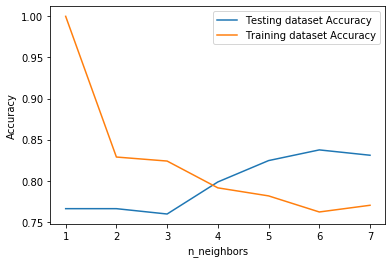

In [44]:
# RS: 345

# Import necessary modules 
from sklearn.neighbors import KNeighborsClassifier 

# Split into training and test set 
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    label, 
                                                    test_size = 0.2, 
                                                    random_state= 345)

neighbors = np.arange(1, 8) 
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors)) 

# Loop over K values 
for i, k in enumerate(neighbors):
    model_knn = KNeighborsClassifier(n_neighbors=k)
    model_knn.fit(X_train, y_train)
    
    # Compute traning and test data accuracy 
    train_accuracy[i] = model_knn.score(X_train, y_train) 
    test_accuracy[i] = model_knn.score(X_test, y_test) 

# Generate plot 
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy') 

plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy') 

### Best KNN Model (n_neighbors=6, RS: 345)

In [45]:
# Import necessary modules 
from sklearn.neighbors import KNeighborsClassifier 

# Split into training and test set 
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size = 0.2, random_state=345) 

model_knn = KNeighborsClassifier(n_neighbors=6) 

model_knn.fit(X_train, y_train) 

# Calculate the accuracy of the model 
test_score_knn = model_knn.score(X_test, y_test)
train_score_knn = model_knn.score(X_train, y_train)


print("Test Score: {:.3f} \nTrain Score: {:3f} \nGeneralised Model".format(test_score_knn, train_score_knn))

Test Score: 0.838 
Train Score: 0.762215 
Generalised Model


### Confusion Matrix & Classification Report | KNN

array([[99,  9],
       [16, 30]], dtype=int64)

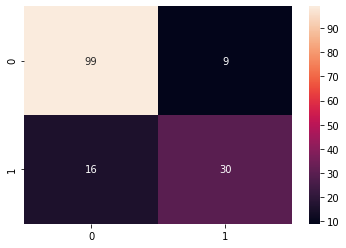

In [46]:
cm_knn = confusion_matrix(y_test,model_knn.predict(X_test))

sns.heatmap(cm_knn, annot=True)

cm_knn

In [47]:
report_knn = classification_report(label,model_knn.predict(features), output_dict=True)

report_knn_df = pd.DataFrame(report_knn).transpose()

print(report_knn_df)

print("\n{:.3f} is the critical accuracy of this model".format((0.783133 + 0.529851) / 2))

Eval_metric_rk_knn = (0.783133 + 0.529851) / 2

              precision    recall  f1-score     support
0              0.783133  0.910000  0.841813  500.000000
1              0.759358  0.529851  0.624176  268.000000
accuracy       0.777344  0.777344  0.777344    0.777344
macro avg      0.771245  0.719925  0.732994  768.000000
weighted avg   0.774836  0.777344  0.765867  768.000000

0.656 is the critical accuracy of this model


In [48]:
# From the Confusion Matrix: 
# There are 90 Records where an actually Diabetic person is labeled Non-Diabetic (Cannot be tolerated)
# Hence We need to also check Precision of '0' and Recall of '1' 

# 0.656 is the critical accuracy of 'KNN' model -- By Rohan Kunte

In [49]:
# df.head()

df_features = df[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']]
df_label = df['Outcome']

In [50]:
from sklearn.model_selection import cross_val_score

# for i in range(2,30):
#     if ((cross_val_score(model_knn , X_train, y_train, cv = i)).mean()) > 0.74:
#         print((cross_val_score(model_knn , X_train, y_train, cv = i)).mean(), i)

cross_val_score(model_knn , df_features, df_label, cv = 7).mean()

0.7227808888359347

## <font color = red>Logistic Regression </font>

### For Loop for Best Model

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


for i in range(1, 1000):
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                        label,
                                                        test_size=0.2,
                                                        random_state=i)

    model_logReg = LogisticRegression()
    model_logReg.fit(X_train, y_train)

    train_score = model_logReg.score(X_train, y_train)
    test_score = model_logReg.score(X_test, y_test)

    if (i % 100 == 0):
        print("currently at RS: ", i)

    if ((test_score > train_score) & (test_score > 0.86)):
        print("test: {:.3f}, train: {:.3f}, RS: {}".format(test_score,
                                                           train_score,
                                                           i))

currently at RS:  100
currently at RS:  200
currently at RS:  300
currently at RS:  400
currently at RS:  500
currently at RS:  600
test: 0.870, train: 0.752, RS: 645
currently at RS:  700
currently at RS:  800
currently at RS:  900


In [52]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression


# for i in range(1, 1000):
#     X_train, X_test, y_train, y_test = train_test_split(features,
#                                                         label,
#                                                         test_size=0.2,
#                                                         random_state=i)

#     model_logReg = LogisticRegression()
#     model_logReg.fit(X_train, y_train)

#     train_score = model_logReg.score(X_train, y_train)
#     test_score = model_logReg.score(X_test, y_test)

#     if (i % 100 == 0):
#         print("currently at RS: ", i)

#     if ((test_score > train_score) & (test_score > 0.86)):
#         print("test: {:.3f}, train: {:.3f}, RS: {}".format(test_score,
#                                                            train_score,
#                                                            i))

# # features: test: 0.870, train: 0.752, RS: 645 (BEST MODEL ACCURACY)

# # features_NEW: test: 0.851, train: 0.757, RS: 395 (With Feature Engineering)
# # features_overSampling: test: 0.827, train: 0.767, RS: 706 (With Over Sampling)

### Best Logistic Regression Model

In [53]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                        label, 
                                                        test_size=0.2, 
                                                        random_state=645)

model_LogReg = LogisticRegression()
model_LogReg.fit(X_train, y_train)

train_score_LogReg = model_LogReg.score(X_train, y_train)
test_score_LogReg = model_LogReg.score(X_test, y_test)

coeff_LogReg = list(model_LogReg.coef_[0])

print("Generalised Model: test score {:.2f}% > train score {:.2f}%".format(test_score_LogReg*100, train_score_LogReg*100))

Generalised Model: test score 87.01% > train score 75.24%


Text(0.5, 0, 'Importance')

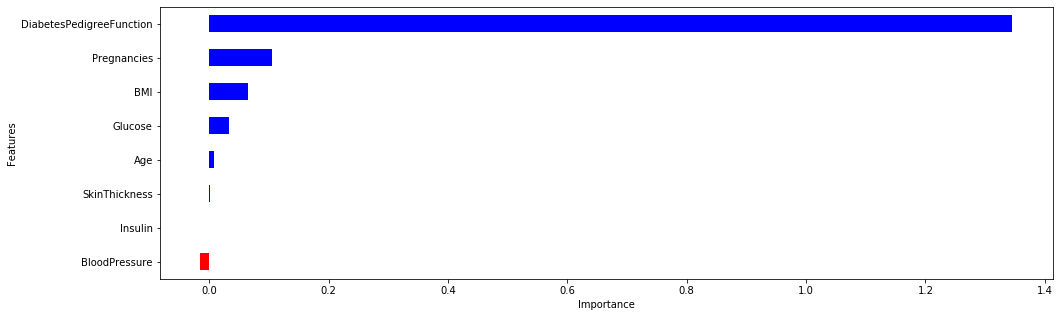

In [54]:
LogReg_df = pd.DataFrame()
LogReg_df['Features'] = feat_colNames
LogReg_df['Importance'] = coeff_LogReg
LogReg_df.sort_values(by=['Importance'], ascending=True, inplace=True)
LogReg_df['Positive'] = (LogReg_df['Importance'] > 0)
LogReg_df.set_index('Features', inplace=True)
LogReg_df.Importance.plot(kind='barh', figsize=(16, 5),color = LogReg_df.Positive.map({True: 'blue', False: 'red'}))
plt.xlabel('Importance')

__THE ABOVE FIGURE AGREES WITH OUT FEATURE ENGINEERING INFERENCE__

### Confusion Matrix & Classification Report | Logistic Regression

[[102   6]
 [ 14  32]]


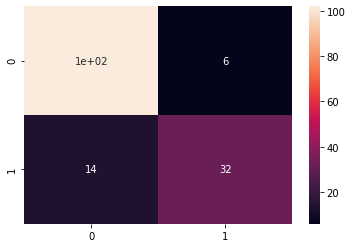

In [55]:
from sklearn.metrics import confusion_matrix

cm_LogReg = confusion_matrix(y_test,model_LogReg.predict(X_test))
print(cm_LogReg)

sns.heatmap(cm_LogReg, annot=True)


#     0     1
# 0  443   57

# 1  115   153

In [56]:
from sklearn.metrics import classification_report

report_LogReg = classification_report(label,model_LogReg.predict(features), output_dict=True)

report_LogReg_df = pd.DataFrame(report_LogReg).transpose()

print(report_LogReg_df)

print("\n{:.3f} is the critical accuracy of this model".format((0.793907 + 0.570896) / 2))

Eval_metric_rk_LogReg = (0.793907 + 0.570896) / 2

              precision    recall  f1-score     support
0              0.793907  0.886000  0.837429  500.000000
1              0.728571  0.570896  0.640167  268.000000
accuracy       0.776042  0.776042  0.776042    0.776042
macro avg      0.761239  0.728448  0.738798  768.000000
weighted avg   0.771107  0.776042  0.768593  768.000000

0.682 is the critical accuracy of this model


In [57]:
# From the Confusion Matrix: 
# There are 115 Records where a potentially Diabetic person is labeled 'Healthy' (Cannot be tolerated)
# Hence We need to also check Precision of '0' and Recall of '1' 

# 0.682 is the critical accuracy of 'Logistic Regression' model -- By Rohan Kunte

##  <font color = red>Decision Tree Classifier</font>

### For Loop to find the best model

In [58]:
from sklearn.tree import DecisionTreeClassifier

for d in range(5,6):
    print(d)
    for i in range(1,1000):
        X_train, X_test, y_train, y_test = train_test_split(features,
                                                            label, 
                                                            test_size=0.2,
                                                            random_state = i)
        model_DT = DecisionTreeClassifier(max_depth = d)

        model_DT.fit(X_train, y_train)

        train_score_dt = model_DT.score(X_train, y_train)
        test_score_dt = model_DT.score(X_test, y_test)

        if test_score_dt > train_score_dt:
            print(test_score_dt,train_score_dt, d,i)

5
0.8246753246753247 0.8094462540716613 5 194
0.8376623376623377 0.8322475570032574 5 345
0.8181818181818182 0.8143322475570033 5 991


### Best Decision Tree Model

In [59]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    label,
                                                    test_size=0.2,
                                                    random_state = 345)

model_DT = DecisionTreeClassifier(max_depth=5)

model_DT.fit(X_train,y_train)

train_score_dt = model_DT.score(X_train,y_train)
test_score_dt = model_DT.score(X_test,y_test)

print("'Generalised' Decision Tree Classifier Model with: \nTest Score: {:.3f} and Train Score: {:.3f}".format(test_score_dt, train_score_dt))

'Generalised' Decision Tree Classifier Model with: 
Test Score: 0.844 and Train Score: 0.832


In [60]:
cross_val_score(model_DT , df_features, df_label, cv = 4).mean()

0.7565104166666666

### Confusion Matrix & Classification Report | Decision Tree Classifier

array([[93, 15],
       [ 9, 37]], dtype=int64)

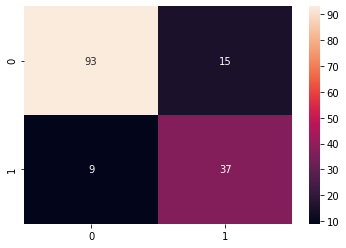

In [61]:
cm_dt = confusion_matrix(y_test,model_DT.predict(X_test))
sns.heatmap(cm_dt, annot=True)
cm_dt

In [62]:
report_dt = classification_report(label,model_DT.predict(features), output_dict=True)

report_dt_df = pd.DataFrame(report_dt).transpose()

print(report_dt_df)

print("\n{:.3f} is the critical accuracy of this model".format((0.857692 + 0.723881) / 2))

Eval_metric_rk_dt = (0.857692 + 0.723881) / 2

              precision    recall  f1-score     support
0              0.859345  0.892000  0.875368  500.000000
1              0.783133  0.727612  0.754352  268.000000
accuracy       0.834635  0.834635  0.834635    0.834635
macro avg      0.821239  0.809806  0.814860  768.000000
weighted avg   0.832750  0.834635  0.833138  768.000000

0.791 is the critical accuracy of this model


In [63]:
# From the Confusion Matrix: 
# There are 74 Records where a potentially Diabetic person is labeled 'Healthy' (Cannot be tolerated)
# Hence We need to also check Precision of '0' and Recall of '1' 

# 0.791 is the critical accuracy of 'Decision Tree Classifier' model -- By Rohan Kunte

##  <font color = red>Random Forest Classifier</font>

### Find the Best Random Forest Classifier Model 

In [64]:
# from sklearn.ensemble import RandomForestClassifier

# train_rf = []
# test_rf = []
# for i in range(701):
#         X_train, X_test, y_train, y_test = train_test_split(features_overSampling,
#                                                             label_overSampling, 
#                                                             test_size=0.2,
#                                                             random_state = i)
#         model_rf = RandomForestClassifier()

#         model_rf.fit(X_train,y_train)

#         test_score_rf = model_rf.score(X_test,y_test)
#         train_score_rf = model_rf.score(X_train,y_train)
        
#         train_rf.append(train_score_rf)
#         test_rf.append(test_score_rf)
        
#         if i%10 == 0:
#             print("Currently at: ", i)

            
#         if test_score_rf > train_score_rf:
#             print(test_score_rf,train_score_rf,i)

In [65]:
# rf_not_fit = sns.lineplot(range(0,1000),test_rf)
# rf_not_fit = sns.lineplot(range(0,1000), train_rf)
# rf_not_fit.set_title('Random Forest Classifier Not fit for this Dataset')

In [66]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    label, 
                                                    test_size=0.2,
                                                    random_state = 95)

model_rf = RandomForestClassifier(n_estimators=40)
model_rf.fit(X_train, y_train)

test_score_rf = model_rf.score(X_test, y_test)
train_score_rf = model_rf.score(X_train,y_train)

print(test_score_rf, train_score_rf)

0.7727272727272727 0.998371335504886


### Confusion Matrix & Classification Report | Random Forest Classifier

array([[485,  15],
       [ 21, 247]], dtype=int64)

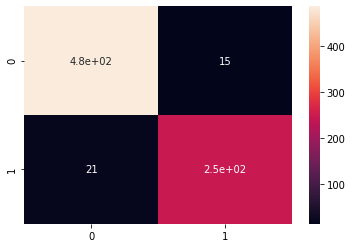

In [67]:
cm_rf = confusion_matrix(label,model_rf.predict(features))
sns.heatmap(cm_rf, annot= True)
cm_rf

In [68]:
report_rf = classification_report(label,model_rf.predict(features), output_dict=True)

report_rf_df = pd.DataFrame(report_rf).transpose()

print(report_rf_df)

print("\n{:.3f} is the critical accuracy of this model".format((0.965517 + 0.936567 ) / 2))

Eval_metric_rk_rf = (0.965517 + 0.936567 ) / 2

              precision    recall  f1-score     support
0              0.958498  0.970000  0.964215  500.000000
1              0.942748  0.921642  0.932075  268.000000
accuracy       0.953125  0.953125  0.953125    0.953125
macro avg      0.950623  0.945821  0.948145  768.000000
weighted avg   0.953002  0.953125  0.952999  768.000000

0.951 is the critical accuracy of this model


In [69]:
#Not generalised (Need more data)

##  <font color = red>Support Vector Machine Classifier</font>

### Finding the Best Model

In [70]:
from sklearn.svm import SVC 

for i in range(1, 400):
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                        label,
                                                        test_size=0.2,
                                                        random_state=i)

    model_svc = SVC(kernel='poly')
    model_svc.fit(X_train, y_train)

    train_score_svc = model_svc.score(X_train, y_train)
    test_score_svc = model_svc.score(X_test, y_test)

    if (i % 100 == 0):
        print("currently at RS: ", i)

    if (test_score_svc > train_score_svc) & (test_score_svc > 0.86):
        print("test: {:.3f}, train: {:.3f}, RS: {}".format(test_score_svc,
                                                           train_score_svc,
                                                           i))
# test: 0.864, train: 0.752, RS: 395

currently at RS:  100
currently at RS:  200
currently at RS:  300
test: 0.864, train: 0.752, RS: 395


### Best SVC Model

In [71]:
from sklearn.svm import SVC 

X_train, X_test, y_train, y_test = train_test_split(features,
                                                        label,
                                                        test_size=0.2,
                                                        random_state=395)
model_svc = SVC(kernel='poly', probability=True)

model_svc.fit(X_train,y_train)

SVC(kernel='poly', probability=True)

### Confusion Matrix & Classification Report | SVC

array([[107,   9],
       [ 12,  26]], dtype=int64)

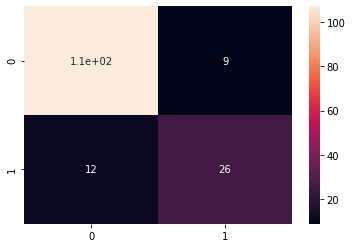

In [72]:
cm_svc = confusion_matrix(y_test,model_svc.predict(X_test))
sns.heatmap(cm_svc, annot= True)
cm_svc

In [73]:
report_svc = classification_report(label,model_svc.predict(features), output_dict=True)

report_svc_df = pd.DataFrame(report_svc).transpose()

print(report_svc_df)

print("\n{:.3f} is the critical accuracy of this model".format((0.785340 + 0.541045 ) / 2))

Eval_metric_rk_svc = (0.785340 + 0.541045 ) / 2

              precision    recall  f1-score    support
0              0.785340  0.900000  0.838770  500.00000
1              0.743590  0.541045  0.626350  268.00000
accuracy       0.774740  0.774740  0.774740    0.77474
macro avg      0.764465  0.720522  0.732560  768.00000
weighted avg   0.770771  0.774740  0.764644  768.00000

0.663 is the critical accuracy of this model


In [74]:
# From the Confusion Matrix: 
# There are 123 Records where a potentially 'Diabetic' person is labeled 'Healthy' (Cannot be tolerated)
# Hence We need to also check Precision of '0' and Recall of '1' 

# 0.663 is the critical accuracy of 'Support Vector Machine Classifier' model -- By Rohan Kunte

# <font color = red>Results</font>

In [75]:
# We can compare the following Results:

# 1. KNN
# 2. Logistic Regression
# 3. Decision Tree Classifier
# 4. Random Forest Classifier (Rejected because no Generalised Model)
# 5. Support Vector Classifier

# cm_dt , cm_knn, cm_LogReg, cm_svc

AUC_knn: 0.845
AUC_svc: 0.841
AUC_LogReg: 0.842
AUC_rf: 0.990
AUC_DT: 0.907


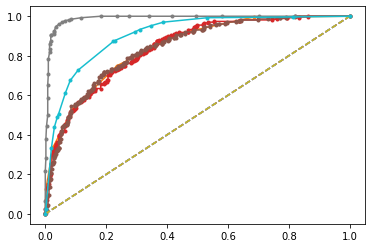

In [76]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

AUC = []

probs_knn = model_knn.predict_proba(features)
probs_knn = probs_knn[:, 1]

auc_knn = roc_auc_score(label, probs_knn)
print('AUC_knn: %.3f' % auc_knn)

fpr_knn, tpr_knn, thresholds_knn = roc_curve(label, probs_knn)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_knn, tpr_knn, marker='.')

###############


probs_svc = model_svc.predict_proba(features)

probs_svc = probs_svc[:, 1]

auc_svc = roc_auc_score(label, probs_svc)
print('AUC_svc: %.3f' % auc_svc)

fpr_svc, tpr_svc, thresholds_svc = roc_curve(label, probs_svc)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_svc, tpr_svc, marker='.')

###############

probs_LogReg = model_LogReg.predict_proba(features)
probs_LogReg = probs_LogReg[:, 1]

auc_LogReg = roc_auc_score(label, probs_LogReg)
print('AUC_LogReg: %.3f' % auc_LogReg)

fpr_LogReg, tpr_LogReg, thresholds_LogReg = roc_curve(label, probs_LogReg)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_LogReg, tpr_LogReg, marker='.')

###############

probs_rf = model_rf.predict_proba(features)
probs_rf = probs_rf[:, 1]

auc_rf = roc_auc_score(label, probs_rf)
print('AUC_rf: %.3f' % auc_rf)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(label, probs_rf)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_rf, tpr_rf, marker='.')

###############

probs_DT = model_DT.predict_proba(features)
probs_DT = probs_DT[:, 1]

auc_DT = roc_auc_score(label, probs_DT)
print('AUC_DT: %.3f' % auc_DT)

fpr_DT, tpr_DT, thresholds_DT = roc_curve(label, probs_DT)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_DT, tpr_DT, marker='.')

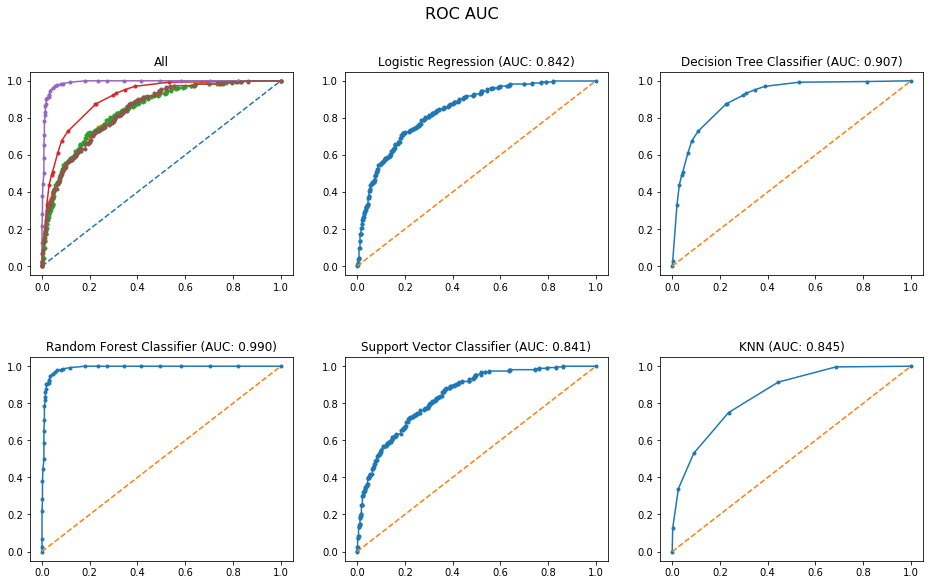

In [77]:
'KNN', 'Logistic Regression', 'Decision Tree Classifier','Random Forest Classifier', 'Support Vector Classifier'

fig_5,a =  plt.subplots(2,3, figsize=(16, 9))

a[0][0].plot([0, 1], [0, 1], linestyle='--')
a[0][0].plot(fpr_knn, tpr_knn, marker='.')
a[0][0].plot(fpr_LogReg, tpr_LogReg, marker='.')
a[0][0].plot(fpr_DT, tpr_DT, marker='.')
a[0][0].plot(fpr_rf, tpr_rf, marker='.')
a[0][0].plot(fpr_svc, tpr_svc, marker='.')
a[0][0].set_title('All')

a[1][2].plot(fpr_knn, tpr_knn, marker='.')
a[1][2].plot([0, 1], [0, 1], linestyle='--')
a[1][2].set_title('KNN (AUC: {:.3f})'.format(auc_knn))

a[0][1].plot(fpr_LogReg, tpr_LogReg, marker='.')
a[0][1].plot([0, 1], [0, 1], linestyle='--')
a[0][1].set_title('Logistic Regression (AUC: {:.3f})'.format(auc_LogReg))


a[0][2].plot(fpr_DT, tpr_DT, marker='.')
a[0][2].plot([0, 1], [0, 1], linestyle='--')
a[0][2].set_title('Decision Tree Classifier (AUC: {:.3f})'.format(auc_DT))

a[1][0].plot(fpr_rf, tpr_rf, marker='.')
a[1][0].plot([0, 1], [0, 1], linestyle='--')
a[1][0].set_title('Random Forest Classifier (AUC: {:.3f})'.format(auc_rf))

a[1][1].plot(fpr_svc, tpr_svc, marker='.')
a[1][1].plot([0, 1], [0, 1], linestyle='--')
a[1][1].set_title('Support Vector Classifier (AUC: {:.3f})'.format(auc_svc))

fig_5.suptitle('ROC AUC', fontsize=16)
plt.subplots_adjust(hspace=0.4, wspace=0.2)

PR_knn: 0.765616674252094
PR_LogReg: 0.765616674252094
PR_DT: 0.8157728266749942
PR_rf: 0.9767708343498605
PR_svc: 0.7376167519740362


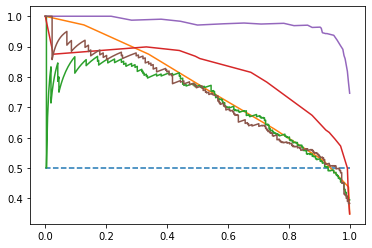

In [78]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

PR = []

probabilityValues_knn = model_knn.predict_proba(features)[:, 1]

precision_knn, recall_knn, threshold_knn = precision_recall_curve(label, probabilityValues_knn)

auc_pr_knn = auc(recall_knn, precision_knn)

print("PR_knn: {}".format(auc_pr_knn))

plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.plot(recall_knn, precision_knn)

#############################################################################################

probabilityValues_LogReg = model_LogReg.predict_proba(features)[:, 1]

precision_LogReg, recall_LogReg, threshold_LogReg = precision_recall_curve(label, probabilityValues_LogReg)

auc_pr_LogReg = auc(recall_LogReg, precision_LogReg)

print("PR_LogReg: {}".format(auc_pr_knn))

# plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.plot(recall_LogReg, precision_LogReg)

#############################################################################################

probabilityValues_DT = model_DT.predict_proba(features)[:, 1]

precision_DT, recall_DT, threshold_DT = precision_recall_curve(label, probabilityValues_DT)

auc_pr_DT = auc(recall_DT, precision_DT)

print("PR_DT: {}".format(auc_pr_DT))

# plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.plot(recall_DT, precision_DT)

#############################################################################################

probabilityValues_rf = model_rf.predict_proba(features)[:, 1]

precision_rf, recall_rf, threshold_rf = precision_recall_curve(label, probabilityValues_rf)

auc_pr_rf = auc(recall_rf, precision_rf)

print("PR_rf: {}".format(auc_pr_rf))

# plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.plot(recall_rf, precision_rf)

#############################################################################################

probabilityValues_svc = model_svc.predict_proba(features)[:, 1]

precision_svc, recall_svc, threshold_svc = precision_recall_curve(label, probabilityValues_svc)

auc_pr_svc = auc(recall_svc, precision_svc)

print("PR_svc: {}".format(auc_pr_svc))

# plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.plot(recall_svc, precision_svc)




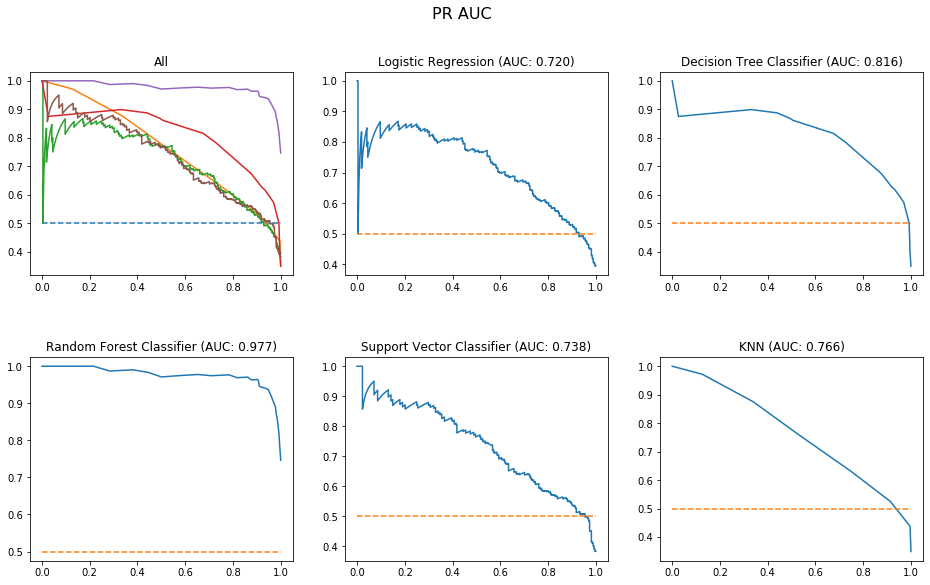

In [79]:
'KNN', 'Logistic Regression', 'Decision Tree Classifier','Random Forest Classifier', 'Support Vector Classifier'

fig_5,a =  plt.subplots(2,3, figsize=(16, 9))

a[0][0].plot([0, 1], [0.5, 0.5], linestyle='--')
a[0][0].plot(recall_knn, precision_knn)
a[0][0].plot(recall_LogReg, precision_LogReg)
a[0][0].plot(recall_DT, precision_DT)
a[0][0].plot(recall_rf, precision_rf)
a[0][0].plot(recall_svc, precision_svc)
a[0][0].set_title('All')

a[1][2].plot(recall_knn, precision_knn)
a[1][2].plot([0, 1], [0.5, 0.5], linestyle='--')
a[1][2].set_title('KNN (AUC: {:.3f})'.format(auc_pr_knn))

a[0][1].plot(recall_LogReg, precision_LogReg)
a[0][1].plot([0, 1], [0.5, 0.5], linestyle='--')
a[0][1].set_title('Logistic Regression (AUC: {:.3f})'.format(auc_pr_LogReg))


a[0][2].plot(recall_DT, precision_DT)
a[0][2].plot([0, 1], [0.5, 0.5], linestyle='--')
a[0][2].set_title('Decision Tree Classifier (AUC: {:.3f})'.format(auc_pr_DT))

a[1][0].plot(recall_rf, precision_rf)
a[1][0].plot([0, 1], [0.5, 0.5], linestyle='--')
a[1][0].set_title('Random Forest Classifier (AUC: {:.3f})'.format(auc_pr_rf))

a[1][1].plot(recall_svc, precision_svc)
a[1][1].plot([0, 1], [0.5, 0.5], linestyle='--')
a[1][1].set_title('Support Vector Classifier (AUC: {:.3f})'.format(auc_pr_svc))

fig_5.suptitle('PR AUC', fontsize=16)
plt.subplots_adjust(hspace=0.4, wspace=0.2)

In [80]:
cm = [cm_knn, cm_LogReg, cm_dt, cm_rf, cm_svc]

def Sen_Spec(cm):
    Total = sum(sum(cm))
    
    Accuracy = (cm[0,0] + cm[1,1]) / Total
    
    Specificity = cm[0,0] / (cm[0,0] + cm[0,1])
    
    Sensitivity = cm[1,1] / (cm[1,0] + cm[1,1])
    
    return(Sensitivity, Specificity)

sen_knn, spec_knn = Sen_Spec(cm_knn)
sen_LogReg, spec_LogReg = Sen_Spec(cm_LogReg)
sen_dt, spec_dt = Sen_Spec(cm_dt)
sen_rf, spec_rf = Sen_Spec(cm_rf)
sen_svc, spec_svc = Sen_Spec(cm_svc)

Sensitivities = [sen_knn, sen_LogReg, sen_dt, sen_rf, sen_svc]
Specificities = [spec_knn, spec_LogReg, spec_dt, spec_rf, spec_svc]

In [81]:
df_results = pd.DataFrame()

df_results['Model_Name'] = ['KNN', 'Logistic Regression', 'Decision Tree Classifier',
                            'Random Forest Classifier', 'Support Vector Classifier']

df_results['Test_Score'] = [test_score_knn, test_score_LogReg,
                            test_score_dt, test_score_rf, test_score_svc]

df_results['Train_Score'] = [train_score_knn, train_score_LogReg,
                             train_score_dt, train_score_rf, train_score_svc]

df_results['Generalised'] = [True, True, True, False, True]

df_results['Eval_Metric_RK'] = [Eval_metric_rk_knn, Eval_metric_rk_LogReg,
                                Eval_metric_rk_dt, Eval_metric_rk_rf, Eval_metric_rk_svc]

df_results['ROC_AUC'] = [auc_knn, auc_LogReg, auc_DT, auc_rf, auc_svc]

df_results['PR AUC'] = [auc_pr_knn, auc_pr_LogReg, auc_pr_DT, auc_pr_rf, auc_pr_svc]

df_results['Sensitivity / Recall "1"'] = Sensitivities

df_results['Specificity / Recall "0"'] = Specificities

df_results_new = df_results.set_index('Model_Name', drop=True)
df_results_new

,Test_Score,Train_Score,Generalised,Eval_Metric_RK,ROC_AUC,PR AUC,"Sensitivity / Recall ""1""","Specificity / Recall ""0"""
Model_Name,,,,,,,,
KNN,0.837662,0.762215,True,0.656492,0.844627,0.765617,0.652174,0.916667
Logistic Regression,0.870130,0.752443,True,0.682401,0.841530,0.719541,0.695652,0.944444
Decision Tree Classifier,0.844156,0.832248,True,0.790787,0.906761,0.815773,0.804348,0.861111
Random Forest Classifier,0.772727,0.998371,False,0.951042,0.989791,0.976771,0.921642,0.970000
Support Vector Classifier,0.753247,0.768730,True,0.663193,0.841381,0.737617,0.684211,0.922414


Text(0.5, 0.98, 'INTOLERABLE CASE: Diabetic Person classified as Diabetic')

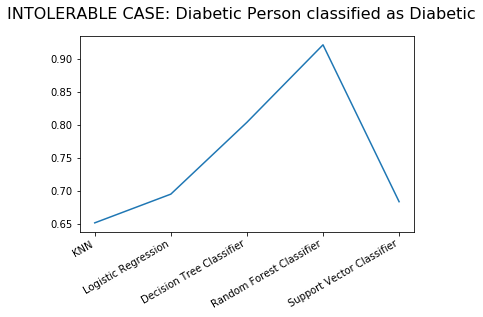

In [82]:
fig, axis = plt.subplots()
axis.plot(df_results_new['Sensitivity / Recall "1"'])
fig.autofmt_xdate()
fig.suptitle('INTOLERABLE CASE: Diabetic Person classified as Diabetic', fontsize=16)